Import the necessary **libraries**

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

## A model is experimented with the two inputs 
* input 1  : an image from MNIST 
* input 2 : A numerical 

Inside the model ,

* mnist image is processed with an intention to predict the number , 
* The last layer is then paired with the 2nd input which is a numeric. 
* and fed to four linear layer to learn the addition of number.
 - One hot encoding of the input number is done to create a 1x10 vector 
 - torch.cat is used pair the predicted number with input number

####  summary of layers with convolution
\begin{array}{ccc}
\text{Layer}&\text{Input}&\text{Output}&\text{Receptive Field}\\
Conv1&28*28*1&28*28*32&3*3\\
Conv2&28*28*32&28*28*64&5*5\\
Pool1&28*28*64&14*14*64&10*10\\
Conv3&14*14*64&14*14*128&12*12\\
Conv4&14*14*128&14*14*256&14*14\\
Pool2&14*14*256&7*7*256&28*28\\
Conv5&7*7*256&5*5*512&30*30\\
Conv6&5*5*512&3*3*1024&32*32\\
Conv7&3*3*1024&1*1*10&34*34\\
\end{array}


#### Adder fully connected layers
\begin{array}{ccc}
\text{Layer}&\text{Input}&\text{Output}\\
fc1&1*1*20&1*1*200\\
fc2&1*1*200&1*1*400\\
fc3&1*1*400&1*1*800\\
fc4&1*1*800&1*1*20\\
\end{array}

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)
        self.fc1 = nn.Linear(9216, 10)
        self.lin1 = nn.Linear(20, 100 , bias = True)
        self.lin2 = nn.Linear(100, 20, bias=False)
        #self.lin2 = nn.Linear(200, 400 , bias = True)
        #self.lin3 = nn.Linear(400, 800 , bias = True)
        #self.lin4 = nn.Linear(800, 20 , bias = False)


    def forward(self, x , x2 = None):
        # process the mnist image
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        
        x = (self.conv7(x))

        x = x.view(-1, 10)

        x = F.log_softmax(x)

        # initialize an empty tensor , this is required to get the model summary
        x_in = torch.empty(x.size()[0], 20)#, dtype=torch.float32)

        # take the mnist image out put and pair with the input number
        if (x2 != None):
          onehotx2 = torch.nn.functional.one_hot(x2 , num_classes=10)

          x_in = torch.cat((x.view(x.size(0), -1),
                          onehotx2.view(onehotx2.size(0), -1)), dim=1)
        
        x_in = x_in.to(device)

        # process the pair to add the numbers
        x_in = self.lin1(x_in)
        x_in = torch.tanh(x_in)
        
        x_in = self.lin2(x_in)
        """x_in = torch.tanh(x_in)

        x_in = self.lin3(x_in)
        x_in = torch.tanh(x_in)

        x_in = self.lin4(x_in)"""

        x_in = x_in.view(-1, 20)
        x_in = F.log_softmax(x_in)
        
        return x_in

## summary
 
\begin{array}{ccc}
\text{Layer}&\text{calculation}&\text{No of parameters}\\
Conv1&3*3*32 + 32(bias)&320\\
Conv2&3*3*32*64 + 64(bias)&18,496\\
Conv3&3*3*64*128 + 128(bias)&73,856\\
Conv4&3*3*128*256 + 256(bias)&295,168\\
Conv5&3*3*256*512 + 512(bias)&1,180,160\\
Conv6&3*3*512*1024 + 1024(bias)&4,719,616\\
Conv7&3*3*1024*10 + 10(bias)&92,170\\
fc1&20*200 + 200(bias)&4200\\
fc2&200*400 + 400(bias)&80400\\
fc3&400*800 + 800(bias)&320800\\
fc4&800*20 + 0(bias)&16000\\
\end{array}

In [3]:
!pip install torchsummary
from torchsummary import summary

# Check if gpu is available 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# direct the model to run in GPU
model = Net().to(device)
# give a summary of the model like output of each layer , number of parameters in each layer
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
           Linear-10                  [-1, 100]           2,100
           Linear-11                   [-1, 20]           2,000
Total params: 6,383,886
Trainable params: 6,383,886
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Pre-processing



*   Take a batch size of 128
*   Call the DataLoader api 
*   > use the MNIST dataset from pytorch
*   > normalize the data - mean = 0.1307 , std = 0.3081
*   > shuffle the data 






In [4]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


### Function to train 

*   model -> set the mode to train 
*   tqdm is used to show progress bar while looping through the train/test dataset
*   while looping through each batch of train data and label
*   create a batch of random integer between 0 - 9 , this is the second input to the model
*   add the labels and second input to create the target label for the adder model
*   set the device for each of the input 
*   set the gradient to zero before doing backpropogation , because pytorch accumulates the gradient on subsequent backward passes. 
*   train the model on each batch 
*   get the crossentropy loss between the predicted label and the true label
*   backpropogate the loss to readjust the parameter weights

*What is the loss function?*

It is crossentropy loss between the predicted sum of two numbers and the actual sum of two numbers

### Function to test 


*   model -> set the mode to eval 
*   disable gradient calculation
*   while looping through each batch of test data and label
*   create a batch of random integer between 0 - 9 , this is the second input to the model
*   add the labels and second input to create the target label for the adder model
*   set the device for each of the input 
*   test the model on each batch 
*   get the crossentropy loss between the predicted label and the true label 
*   sum the batch loss
*   find the number of correct prediction
*   measure the accuracy of the model = correct / total number of records




In [5]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        randinpt =  np.random.randint(low=0, high=10, size=(target.size()[0],))
        randlabel = torch.tensor(randinpt, dtype=torch.int32)
        input2 = torch.tensor(randinpt, dtype=torch.long)
        
        sumLabel = randlabel + target
        data, target = data.to(device), target.to(device)
        input2 , sumLabel  = input2.to(device) , sumLabel.to(device)
        optimizer.zero_grad()
        output = model(data ,input2)
        
        loss = F.cross_entropy(output, sumLabel)
        #loss = torch.nn.functional.nll_loss(output, sumLabel, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        nn.L1Loss()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            randinpttest =  np.random.randint(low=0, high=10, size=(target.size()[0],))
            randlabeltest = torch.tensor(randinpttest, dtype=torch.int32)
            input2test = torch.tensor(randinpttest, dtype=torch.long)
            #input2test = torch.tensor(randinpttest, dtype=torch.float32)
            sumLabeltest = randlabeltest + target

            data, target = data.to(device), target.to(device)
            input2test , sumLabeltest  = input2test.to(device) , sumLabeltest.to(device) 

            output = model(data,input2test)
            test_loss += F.cross_entropy(output, sumLabeltest, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(sumLabeltest.view_as(pred)).sum().item()
            #print('pred ' , pred , '- \n actual - ',sumLabeltest)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss , 100. * correct / len(test_loader.dataset)

### run the model on the train data and evaluate the model on test data

*   Use stochastic gradient descent to backpropogate and upddate the parameters
*   for each epoch , train the model and evaluate it performance on test data



In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
losslist = []
accrylist = []
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    loss , accry = test(model, device, test_loader)
    losslist.append(loss)
    accrylist.append(accry)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7034, Accuracy: 7733/10000 (77%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1245, Accuracy: 9783/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9893/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0764, Accuracy: 9838/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 9750/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9863/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9875/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9907/10000 (99%)



loss=0.037272628396749496 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.0493, Accuracy: 9903/10000 (99%)



## Plot the performance of the model i.e loss and accuracy across epochs



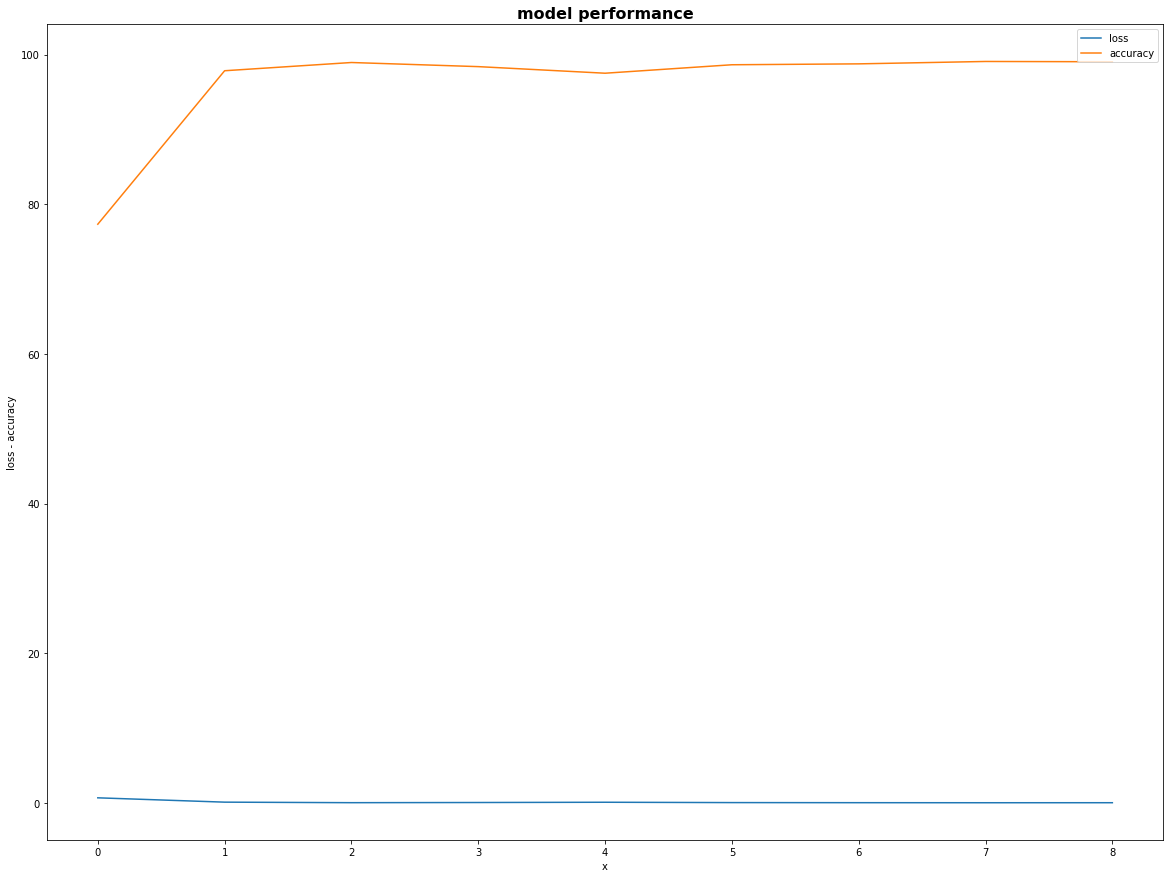

In [7]:
xpoints = np.arange(len(losslist))
ypoints0 = losslist
ypoints2 = accrylist

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(xpoints, ypoints0 , label = "loss")  #"$lr="+str(LRARRAY[0])+"$" )
plt.plot(xpoints, ypoints2, label = "accuracy")

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("x")
plt.ylabel("loss - accuracy")
plt.show()

## Show the model performance on a sample dataset

* Take a batch from the test data
* get the image and label from the batch
* generate a batch of random integers between 0 and 9 , this is input 2
* add the labels and input2 to get the actual sum
* feed the images and input2 to the model to get the predicted sum
* Show the array of predicted sum and actual sum

In [8]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [9]:
batch = next(iter(test_loader))
len(batch)
images, labels = batch

randinpts =  np.random.randint(low=0, high=10, size=(labels.size()[0],))
randlabels = torch.tensor(randinpts, dtype=torch.int32)
input2s = torch.tensor(randinpts, dtype=torch.long)
sumtestlabels = randlabels + labels

images, labels = images.to(device), labels.to(device)
input2s , sumtestlabels  = input2s.to(device) , sumtestlabels.to(device) 

output = model(images,input2s)

predsum = output.argmax(dim=1)   

print('pred -', predsum , '\n - actual sum -',sumtestlabels )

pred - tensor([ 2, 12,  7, 14,  9, 10, 12,  1,  7,  4, 15, 12, 10, 15,  9, 10, 14,  7,
         6, 13,  9, 15,  4,  9,  6, 12, 16, 12,  7,  0,  9, 11,  6, 16, 16, 13,
        13, 10,  6,  7,  7, 11, 10, 18,  6,  3, 12, 11, 14, 13,  7,  9,  6,  4,
         9,  5,  1, 13,  3, 14,  8, 10,  3, 11,  7, 10, 12, 15, 11, 17, 12,  9,
         8,  5,  9,  6, 13, 10,  4, 11,  7, 12,  6, 12,  8,  9,  7, 13, 15,  8,
        12, 11,  3,  7,  4, 12, 17, 18,  9, 11, 11, 10,  6, 14,  8, 15,  7, 11,
        12,  2,  1, 10,  6, 14, 10,  5,  9,  6,  8, 11, 11,  5,  9,  5,  7,  3,
         8, 13], device='cuda:0') 
 - actual sum - tensor([ 2, 12,  7, 14,  9, 10, 12,  1,  7,  4, 15, 12, 10, 15,  9, 10, 14,  7,
         6, 13,  9, 15,  4,  9,  6, 12, 16, 12,  7,  0,  9, 11,  6, 16, 16, 13,
        13, 10,  6,  7,  7, 11, 10, 18,  6,  3, 12, 11, 14, 13,  7,  9,  8,  4,
         9,  5,  1, 13,  3, 14,  8, 10,  3, 11,  7, 10, 12, 15, 11, 17, 12,  9,
         8,  5,  9,  6, 13, 10,  4, 11,  7, 12,  6, 12,  8,  9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Show the first image from the dataset , it is 0

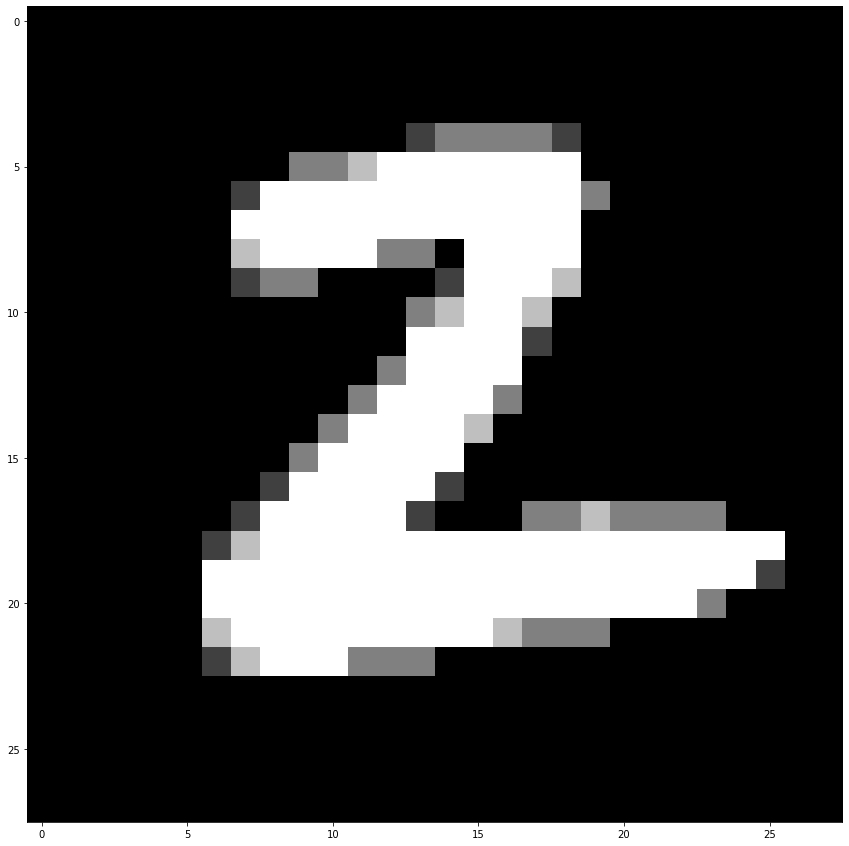

In [16]:
first_image = np.array(images[0].cpu(), dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

### Extract the first entry
* true label of the image
* input 2
* predicted sum
* actual sum

In [11]:
#"\033[1m" + 
result =  'Image label = '+ str(labels[0].cpu().data.numpy())
result2 = 'Input 2 = ' + str(randlabels[0].cpu().data.numpy())
result3 = 'Predicted sum = ' + str(predsum[0].cpu().data.numpy())
result4 = 'Actual sum = ' + str (sumtestlabels[0].cpu().data.numpy())

# Display the above result

In [12]:
from IPython.display import display, Markdown
Markdown('<strong>{}</strong><br><br><strong>{}</strong><br><br><strong>{}</strong><br><br><strong>{}</strong><br><br>'.format(result , result2 , result3 , result4 ))

<strong>Image label = 2</strong><br><br><strong>Input 2 = 0</strong><br><br><strong>Predicted sum = 2</strong><br><br><strong>Actual sum = 2</strong><br><br>